In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
mpl.rcParams['figure.dpi'] = 175
h = 6.6260755e-27 # Planck's constant [erg] [s]
q = 4.803e-10 # electron charge
m_e = 9.109e-28
m_p = 1.6726e-24
c = 2.998e10
h = 6.626e-27

def power_law(gamma, power, A):
    return A * gamma ** (power)

def eV_e(gamma):
    return (gamma*m_e*c**2) / 1.602e-12

def eV_eps(eps):
    return m_e * c**2 * eps / 1.602e-12

def nu_eps(eps):
    return m_e * c**2 * eps / h

def gamma_e(eV):
    return eV / 511000

def eV_p(freq):
    return 4.1357e-13*freq

def make_odd(num):
    if (num % 2 == 0):
        return num + 1
    else:
        return num

In [2]:
def power_law(gamma, power, A):
    return A * gamma ** (power)

# Define the exponential function
def exp_func(gamma, A, b):
    return A * np.exp(b * gamma)


# Function to fit the power law to data
def fit_power_law(gamma_data, y_data):
    # Initial guess for the parameters
    initial_guess = [-1., 1.]
    
    # Fit the curve
    params, params_covariance = curve_fit(power_law, gamma_data, y_data, p0=initial_guess, maxfev=int(1e6))
    
    # Extract the fitted parameters
    fitted_power = params[0]
    fitted_A = params[1]
    
    return fitted_power, fitted_A, params_covariance
def fit_and_plot(x_data, y_data, model="exponential", plot_result=False):
    """
    Fits a model to 2D data and optionally plots the result.

    Parameters:
        x_data (array-like): The x-coordinates of the data.
        y_data (array-like): The y-coordinates of the data.
        model (str): Model to fit ("exponential", "generalized", "power_law").
        plot_result (bool): If True, plots the fitted curve against the data.

    Returns:
        popt (tuple): Optimized parameters for the model.
        pcov (2D array): Covariance matrix of the optimized parameters.
    """
    
    # Define models
    def exponential_model(x, a, b):
        return a * np.exp(b * x)
    
    def generalized_model(x, a, b, c):
        return a * np.exp(b * x) + c
    
    def power_law_model(x, a, b):
        return a * x**b

    # Choose model
    if model == "exponential":
        fit_func = exponential_model
        p0 = [1, 0.1]  # Initial guess
    elif model == "generalized":
        fit_func = generalized_model
        p0 = [1, 0.1, 0]  # Initial guess
    elif model == "power_law":
        fit_func = power_law_model
        p0 = [1, -1]  # Initial guess
    else:
        raise ValueError("Unsupported model. Choose 'exponential', 'generalized', or 'power_law'.")

    # Perform curve fitting
    popt, pcov = curve_fit(fit_func, x_data, y_data, p0=p0, maxfev=10000)
    print(popt)
    # Plot the result if requested
    if plot_result:
        x_fit = np.linspace(min(x_data), max(x_data), 500)
        y_fit = fit_func(x_fit, *popt)
        plt.plot(x_fit, y_fit)

    
    return popt, pcov
def find_powerlaw_transition(x, y, window_length=15, poly_order=2):
    """
    Find the transition point between two power laws in log-log space.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates (e.g., gamma values)
    y : array-like
        y-coordinates (e.g., particle distribution)
    window_length : int, optional
        Window length for Savitzky-Golay filter (must be odd)
    poly_order : int, optional
        Polynomial order for the smoothing filter
        
    Returns:
    --------
    transition_point : float
        x-value where the power law transition occurs
    slopes : tuple
        (slope before transition, slope after transition)
    """
    # Convert to log space
    log_x = np.log10(x)
    log_y = np.log10(y)
    
    # Compute numerical derivative (gradient)
    # First smooth the data to reduce noise
    smooth_log_y = savgol_filter(log_y, window_length, poly_order)
    
    # Calculate gradient using central differences
    gradient = np.gradient(smooth_log_y, log_x)
    
    # Smooth the gradient
    smooth_gradient = savgol_filter(gradient, window_length, poly_order)
    
    # Find where gradient changes most rapidly (second derivative peaks)
    second_derivative = np.abs(np.gradient(smooth_gradient, log_x))
    
    # Find the peak in second derivative
    # Exclude edges to avoid boundary effects
    margin = window_length
    peak_idx = margin + np.argmax(second_derivative[margin:-margin])
    
    # Fit power laws to both regions to get precise slopes
    def power_law(x, alpha, c):
        return c + alpha * x
    
    # Split data at the identified transition point
    split_idx = peak_idx
    
    # Fit before transition
    popt1, _ = curve_fit(power_law, log_x[:split_idx], log_y[:split_idx])
    # Fit after transition
    popt2, _ = curve_fit(power_law, log_x[split_idx:], log_y[split_idx:])
    
    return peak_idx, (popt1[0], popt2[0])

def fit_4th_order(x, y, zorder=0):
    # Fit a 4th order polynomial to the data
    coefficients = np.polyfit(np.log10(x), np.log10(y), 4)
    poly = np.poly1d(coefficients)
    print(np.poly1d(coefficients))
    # Calculate fitted values and errors
    x_fit = np.linspace(min(x), max(x), 100)
    log_y_fit = poly(np.log10(x_fit))
    y_fit = 10**log_y_fit
    # Calculate errors (simplified estimate)
    residuals = np.log10(y) - poly(np.log10(x))
    std_dev = np.std(residuals)
    error_margin = std_dev
    y_fit_lower = 10**(log_y_fit - error_margin)
    y_fit_upper = 10**(log_y_fit + error_margin)
    # Plot the fit and error bands
    plt.fill_between(x_fit, y_fit_lower, y_fit_upper, color='tab:blue', alpha=0.5, label="4th order polynomial fit", zorder=zorder)


## Steady state testing

C:\Users\morga\AppData\Local\Temp\ipykernel_8276\995992482.py:12: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)


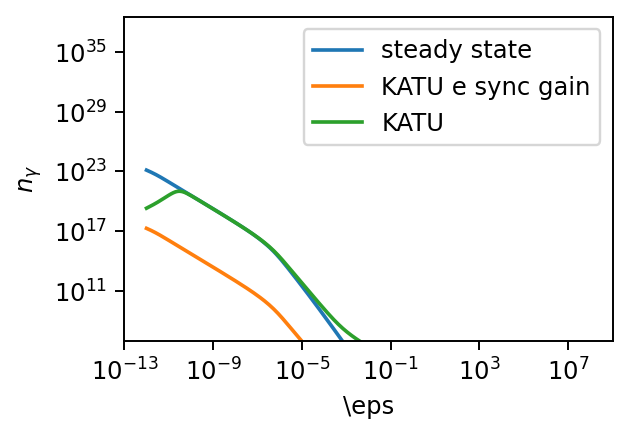

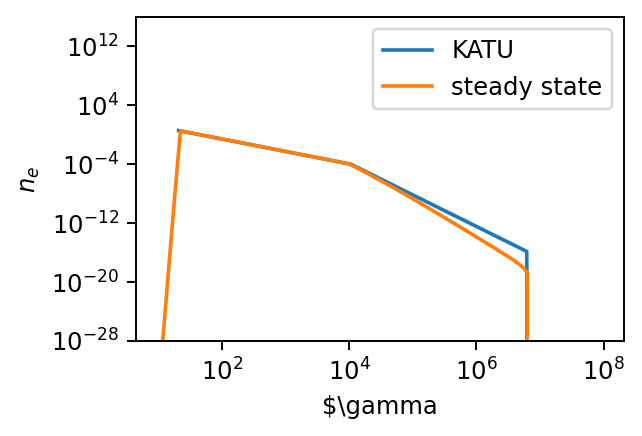

local: 1.04e+02
katu: 1.04e+02
k/l ratio 0.999


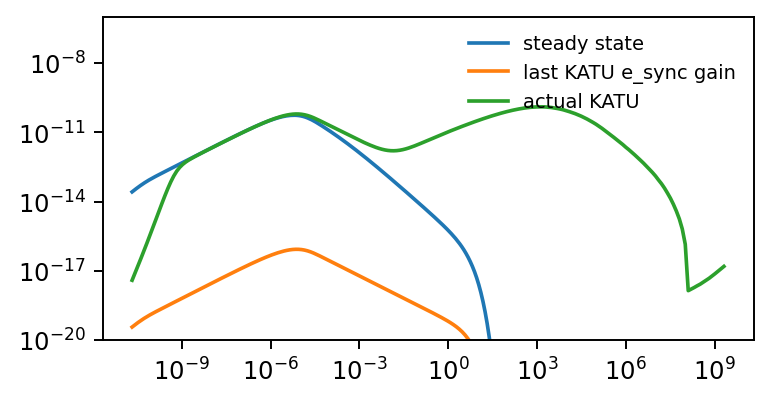

In [21]:
iter = "0016"
time = 9.69263e+06
plt.figure(figsize=[3*1.2,2*1.2])
path = r"\\wsl$\Ubuntu\home\morgan\katu\data"
katu_photon_data = pd.read_csv(path + r"\photon_data_{}.tsv".format(iter), sep="\t", skiprows=1)
katu_electron_data = pd.read_csv(path + r"\lepton_data_{}.tsv".format(iter), sep="\t", skiprows=2)
katu_photon_data.rename(columns=lambda x: x.lstrip('#').strip(), inplace=True)
katu_electron_data.rename(columns=lambda x: x.lstrip('#').strip(), inplace=True)

path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
sim_data = pd.read_csv(path + r"\simulation_data.csv")
run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)

plt.loglog(sim_data["photon_eps"][1:-1], sim_data["photon_n"][1:-1], label="steady state")
plt.loglog(katu_photon_data["Energy"],katu_photon_data["e_sync_gains"], label="KATU e sync gain")
plt.loglog(katu_photon_data["Energy"],katu_photon_data["Population"], label="KATU")

plt.legend()
plt.xlabel("\\eps")
plt.ylabel("$n_\\gamma$")
#plt.set_xlim(1e6)
plt.ylim(1e6,)
plt.show()

plt.figure(figsize=[3*1.2,2*1.2])
plt.loglog(katu_electron_data["Energy"], katu_electron_data["Population"], label="KATU")
#run_data = pd.read_csv(path + r"\runs\run_simulation_data.csv", index_col=False)
plt.loglog(sim_data["gamma"][1:-1], sim_data["electron_n"][1:-1], label="steady state")

plt.legend()
plt.xlabel("$\\gamma")
plt.ylabel("$n_e$")
#plt.set_xlim(1e6)
plt.ylim(1e-28,)
plt.show()

def calc_flux(run_data, Photon_eps, Photon_n):
    # Constants
    Photon_eps = np.array(Photon_eps)
    Photon_n = np.array(Photon_n)
    nu_flux = np.zeros_like(Photon_eps, dtype=np.float64)
    flux_eps = np.zeros_like(Photon_eps, dtype=np.float64)

    c = 3.0e10  # Speed of light in cm/s
    H0 = 2.27e-18  # Hubble constant in cgs
    m_e = 9.109e-28  # Electron mass in grams
    M_PI = np.pi  # Value of pi
    
    # Calculate the luminosity distance from z << 1 approximation
    dL = c * run_data["z"][0] / H0
    V = 4 / 3 * np.pi * run_data["R"][0] ** 3
    # Pre-factor calculation
    pre_fac = (
        m_e * c**2.0 * run_data["doppler_factor"][0]**4.0 * V /
        (4.0 * M_PI * (1.0 + run_data["z"][0]) * dL**2.0 * run_data["tau_esc"][0])
    )   
    
    # Iterate over the array of intrinsic frequencies
    for i in range(0, len(Photon_eps)):
        # Calculate observed frequency for each intrinsic frequency
        eps_obs = run_data["doppler_factor"][0] * Photon_eps[i] / (1.0 + run_data["z"][0])
        # Calculate the flux in the observer frame
        nu_flux[i] = pre_fac * (Photon_eps[i]**2 * Photon_n[i])
        flux_eps[i] = eps_obs
    return flux_eps, nu_flux

integral = 0
integral2 = 0

for i in range(0, len(sim_data["electron_n"])-1):
    integral += 0.5 * (sim_data["electron_n"][i+1] + sim_data["electron_n"][i]) * (sim_data["gamma"][i+1] - sim_data["gamma"][i])

for i in range(0, len(katu_electron_data["Energy"])-1):
    integral2 += 0.5 * (katu_electron_data["Population"][i+1] + katu_electron_data["Population"][i]) * (katu_electron_data["Energy"][i+1] - katu_electron_data["Energy"][i])

print("local: %.2e" % integral)
print("katu: %.2e" % integral2)
print("k/l ratio", round((integral2 / integral),4))

plt.figure(figsize=[4*1.2,2*1.2])
plt.loglog(sim_data["flux_eps"][1:-1], sim_data["nu_flux"][1:-1], label="steady state")
flux_eps, nu_flux = calc_flux(run_data, katu_photon_data["Energy"], katu_photon_data["e_sync_gains"])
plt.loglog(flux_eps, nu_flux, label="last KATU e_sync gain")
flux_eps, nu_flux = calc_flux(run_data, katu_photon_data["Energy"], katu_photon_data["Population"])
plt.loglog(flux_eps, nu_flux, label = "actual KATU")

#plt.loglog(sim_data["flux_eps"][1:-1], sim_data["nu_flux"][1:-1]*time, label="photons * KATU end time")
plt.legend(fontsize = 8, frameon=False, loc="upper right")
plt.ylim(1e-20,1e-6)
plt.show()

C:\Users\morga\AppData\Local\Temp\ipykernel_8276\1851948988.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_8276\1851948988.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_8276\1851948988.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)
C:\Users\morga\AppData\Local\Temp\ipykernel_8276\1851948988.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of d

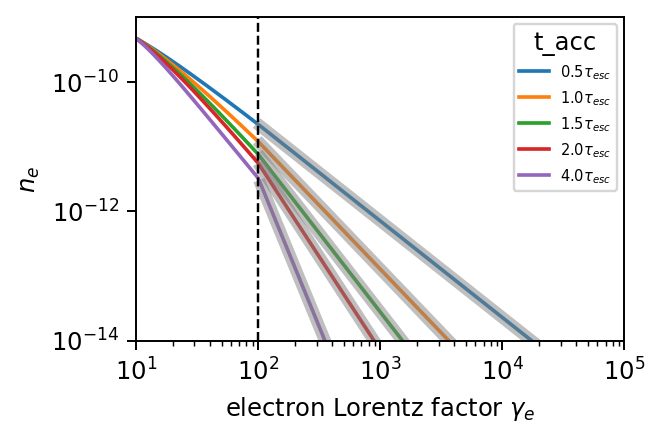

In [4]:
t_esc_multiple = ["0.5","1.0","1.5","2.0","4.0"]
path = r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state"
plt.figure(figsize=[3*1.2,2*1.2])
for multiple in t_esc_multiple:
    sim_data = pd.read_csv(path + fr"\t_acc={multiple}_t_esc.csv")
    run_data = pd.read_csv(path + fr"\runs\run_t_acc={multiple}_t_esc.csv",index_col=False)

    sim_data = sim_data[sim_data["electron_n"] > 1e-20]
    plt.loglog(sim_data["gamma"], sim_data["electron_n"], label ="{}".format(round(run_data["tau_acc"][0]/run_data["tau_esc"][0], 1)) + "$\\tau_{esc}$")
    steady_state_spd = sim_data["gamma"][sim_data["gamma"] > run_data["inject_min"][0] * 10]
    steady_state_time = sim_data["electron_n"][sim_data["gamma"] > run_data["inject_min"][0] * 10]

    p, A, param = fit_power_law(steady_state_spd,steady_state_time)
    plt.plot(steady_state_spd, power_law(steady_state_spd,p,A), "grey", alpha=0.5, lw=5,) #label = f"p = {round(p, 3)}")

plt.vlines(run_data["inject_max"][0], 1e-14, 1e-9,"black", "dashed", lw=1)
plt.legend(title = "t_acc", fontsize=6)
plt.xlabel(r"electron Lorentz factor $\gamma_e$")
plt.ylabel("$n_e$")
plt.xlim(1e1, 1e5)
plt.ylim(1e-14,1e-9)
plt.show()

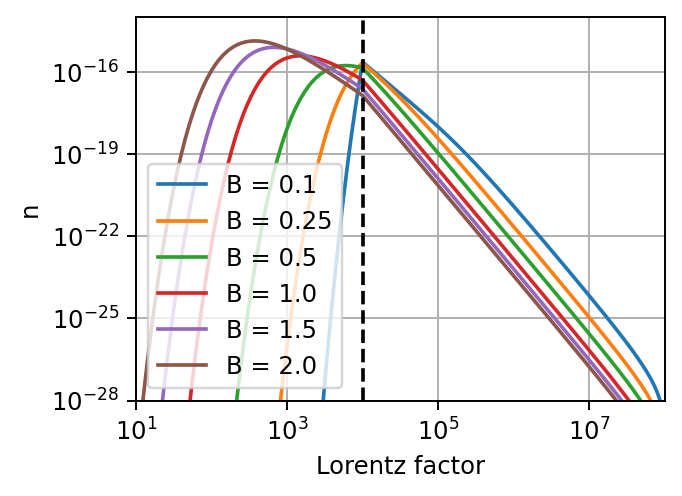

In [5]:
files = ["B0.10.csv","B0.25.csv","B0.50.csv","B1.00.csv","B1.50.csv","B2.00.csv"]
names = ["B = 0.1", "B = 0.25", "B = 0.5", "B = 1.0", "B = 1.5", "B = 2.0"]
plt.figure(figsize=[4,3])
for file, name in zip(files,names): 
    run_data=pd.read_csv(r"C:\Users\morga\Masters Year\Modelling\Mphys_modelling\csv_data\steady_state\{}".format(file),)
    plt.plot(run_data["gamma"], run_data["electron_n"], label=name)
plt.ylabel("n")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Lorentz factor")
plt.xlim(1e1,1e8)
plt.ylim(1e-28,1e-14)
plt.vlines(1e4, 1e-28, 1e-7, "black", "dashed")
plt.legend()
plt.tight_layout()
plt.grid()